In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from sunpy.time import TimeRange
import matplotlib.dates as mdates
import datetime as dt

from scipy.special import erf
from scipy.stats import betaprime, norm, kurtosis

import pandas as pd
import xarray as xr

%matplotlib notebook

/home/ofionnad/realta/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
fname = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:47:00_19563125244140'
sbs = np.arange(76, 320)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 10.*u.min)
"""
fname = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:47:00_19563125244140'
sbs = np.arange(76, 319)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 10.*u.minute)
"""

xlabel = "Time"
ylabel = "Frequency (MHz)"
title = "Jupiter - Stokes I"

In [3]:
def sb_to_f(sbs, obs_mode):
    nyq_dict = {3:1, 5:2, 7:3}
    nyq_zone = nyq_dict[obs_mode]
    clock_dict = {3:200, 4:160, 5:200, 6:160, 7:200} #MHz
    clock = clock_dict[obs_mode]
    nu = (nyq_zone-1. + sbs/512.) * (clock/2.)
    return nu * u.MHz

In [4]:
data = np.memmap(fname, np.float32, mode="c")
data = data.reshape(-1, sbs.shape[0])
data = np.flip(data, axis=1)

times = pd.timedelta_range(start="0 millisecond", periods=data.shape[0], freq='81.92U')
freqs = sb_to_f(sbs, obs_mode)

In [5]:
#dx = xr.DataArray(data, coords=[times, freqs], dims=["Time", "Frequency"])
dx = xr.DataArray(data, coords=[np.arange(len(times)),freqs], dims=["Time", "Frequency"])

In [6]:
dx

<xarray.DataArray (Time: 7324219, Frequency: 244)>
array([[  2615., 289347.,  41109., ...,   2427.,   2237.,   2277.],
       [  3619., 301591.,  47317., ...,   2293.,   2252.,   2654.],
       [  4212., 290845.,  40222., ...,   1676.,   2436.,   2464.],
       ...,
       [   961., 140634., 334643., ...,   2324.,   2282.,   4041.],
       [  1440., 145263., 310870., ...,   2690.,   2636.,   2565.],
       [  1479., 141822., 252601., ...,   1930.,   2026.,   2229.]],
      dtype=float32)
Coordinates:
  * Time       (Time) int64 0 1 2 3 4 ... 7324215 7324216 7324217 7324218
  * Frequency  (Frequency) float64 14.84 15.04 15.23 15.43 ... 61.91 62.11 62.3

In [7]:
### remove strongest RFI channels (just by eye)
#dx = np.ma.masked_greater(dx, 2e4)
#df = np.delete(df, 106, axis=0)
#dx.shape

In [8]:
freqs[30]

<Quantity 20.703125 MHz>

In [53]:
variance = dx.var(axis=0)

In [32]:
kurt = kurtosis(dx, axis=0, fisher=True, )

<IPython.core.display.Javascript object>


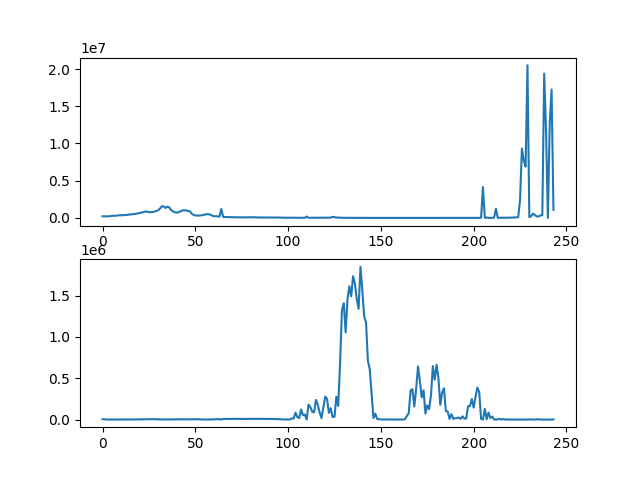

In [33]:
f, ax = plt.subplots(2)
ax[0].plot(variance[::-1])
ax[1].plot(kurt[::-1])

<IPython.core.display.Javascript object>


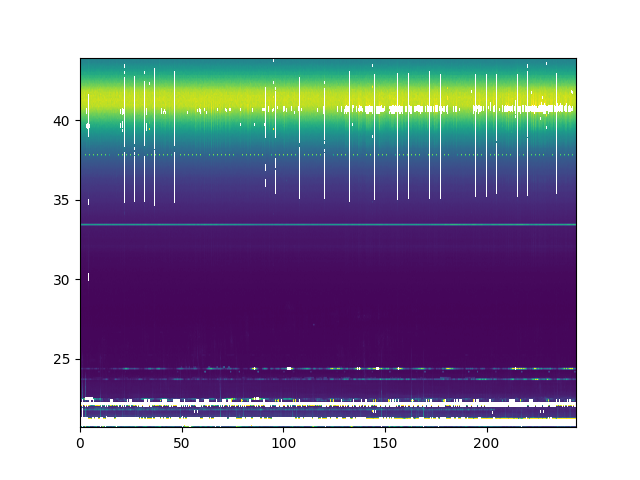

In [38]:
f, ax = plt.subplots()
plt.imshow(dx.T, aspect='auto', origin='lower',
           vmin=np.percentile(dx.T, 5), 
           vmax=np.percentile(dx.T, 95),
#           extent=[x_lims[0], x_lims[1], sb_to_f(116, 3).value, sb_to_f(156, 3).value])
           extent=[0, dx.shape[1], min(freqs[30:150]).value, max(freqs[30:150]).value])

In [86]:
norms = dx.quantile(0.1, dim="Time")

In [87]:
dxn = dx / norms

<IPython.core.display.Javascript object>


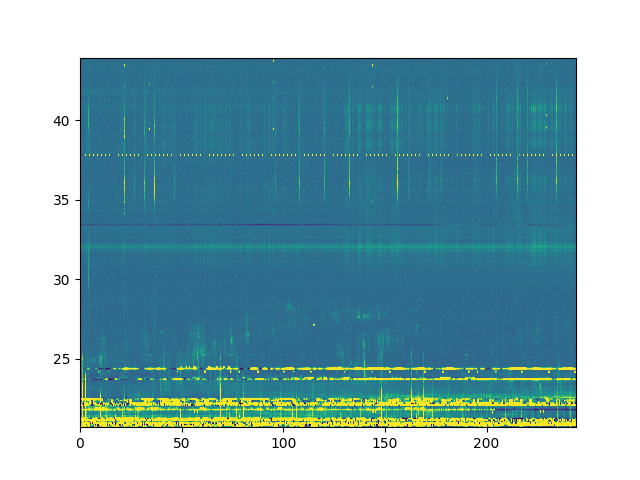

In [88]:
f, ax = plt.subplots()
plt.imshow(dxn.T, aspect='auto', origin='lower',
           vmin=np.percentile(dxn.T, 5), 
           vmax=np.percentile(dxn.T, 95),
#           extent=[x_lims[0], x_lims[1], sb_to_f(116, 3).value, sb_to_f(156, 3).value])
           extent=[0, dxn.shape[1], min(freqs[30:150]).value, max(freqs[30:150]).value])

In [35]:
### spectral kurtosis https://uk.mathworks.com/help/signal/ref/pkurtosis.html

In [36]:
### First take 1 subband. Split it into smaller sections, do a STFT on it with the hamming window

In [ ]:
# take the frequency at 31MHz. 

In [11]:
dt = dx[:,53]

In [155]:
freqs[40]

<Quantity 22.65625 MHz>

In [15]:
splits = np.array_split(dt, 20, axis=0)

In [20]:
splits[0].shape[0]

366211

<IPython.core.display.Javascript object>


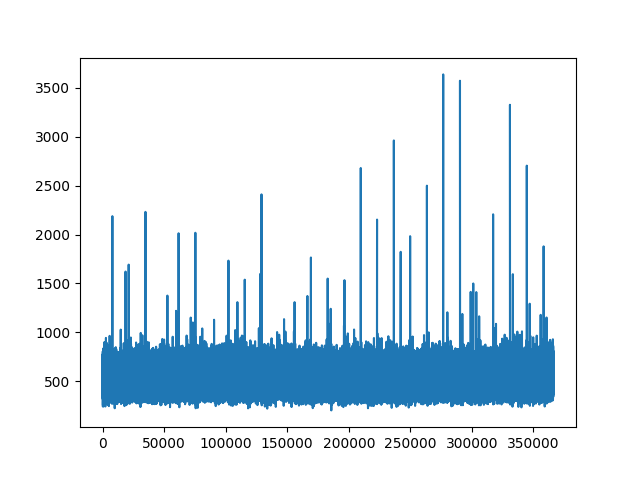

In [19]:
f, ax = plt.subplots()
plt.plot(splits[0])

In [7]:
import pyfftw

In [42]:
_fft = pyfftw.interfaces.numpy_fft.fft(splits[0]*np.hamming(splits[0].shape[0]))

ValueError: operands could not be broadcast together with shapes (366211,) (1024,) 

In [34]:
power = _fft**2

In [35]:
power2 = power**2
_fft4  = _fft**4

In [36]:
sk = (_fft4 / power2) - 2.

In [41]:
sk[1000], sk[10000], sk[100000]

((-1-0j), (-1+0j), (-1+0j))

In [43]:
skk = kurtosis(splits[0])
skft = kurtosis(_fft)

In [48]:
skft

(210564.28466342247+6.1009907565837545e-12j)

<IPython.core.display.Javascript object>


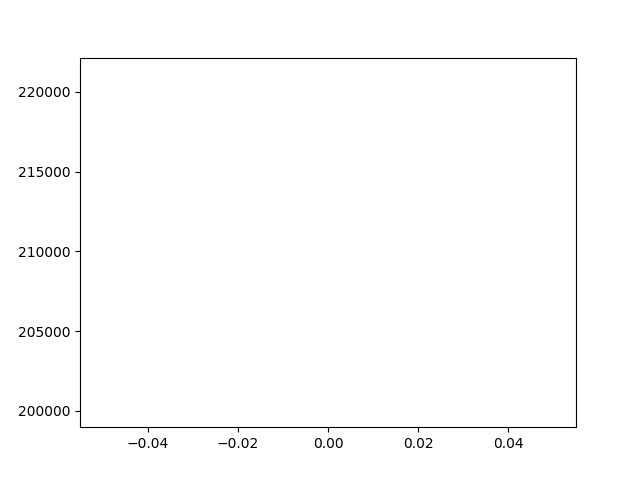

In [45]:
f, ax = plt.subplots()
plt.plot(skft)

In [49]:
### I am not sure why this does not work, but scipy has a stft function I will use for now.

In [7]:
from scipy.signal import stft

In [8]:
dt = dx[:,[53, 130]]

In [9]:
freqs[[53, 130]]

<Quantity [25.1953125, 40.234375 ] MHz>

In [10]:
sft = stft(dt, window='hamming', axis=0, nperseg=564, nfft=2048)

In [11]:
sft[2][:,1,:].shape

(1025, 25974)

<IPython.core.display.Javascript object>


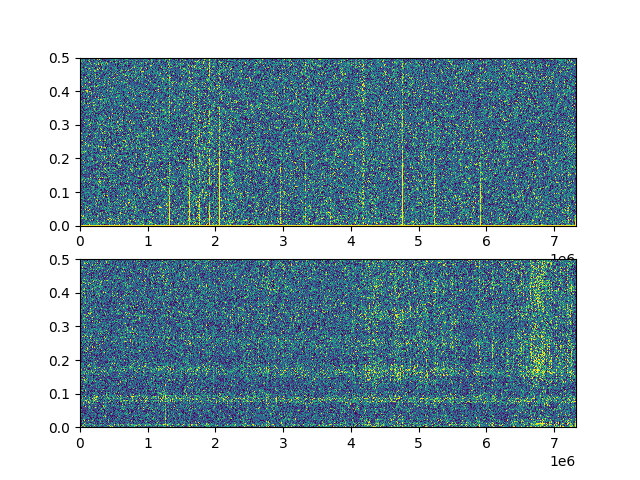

<ipython-input-13-a69c2b340bd4>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(sft[1], sft[0], np.abs(sft[2][:,0,:]),
<ipython-input-13-a69c2b340bd4>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(sft[1], sft[0], np.abs(sft[2][:,1,:]),


In [13]:
f, ax = plt.subplots(2)
ax[0].pcolormesh(sft[1], sft[0], np.abs(sft[2][:,0,:]), shading='auto'
                 vmin=np.percentile(np.abs(sft[2][:,0,:]), 2), 
                 vmax=np.percentile(np.abs(sft[2][:,0,:]), 98))
ax[1].pcolormesh(sft[1], sft[0], np.abs(sft[2][:,1,:]), shading='auto'
                 vmin=np.percentile(np.abs(sft[2][:,1,:]), 2), 
                 vmax=np.percentile(np.abs(sft[2][:,1,:]), 98))

In [14]:
## SK = <STFT>**4 / <STFT**2>**2 - 2.

In [37]:
def sk_threshold(ci, sft_times):
    return (1./ci)*(2./np.sqrt(sft_times))

In [39]:
def g_var(sft_times):
    return 4/sft_times

In [43]:
sft[1].shape

(25974,)

In [44]:
g_var(564)

0.0070921985815602835

In [45]:
sk_threshold(0.95, 564)

0.08864757063858095

In [51]:
def get_sk(stft_arr):
    frac_top = np.mean((np.abs(stft_arr)**4), axis=1)
    frac_bottom = np.mean((np.abs(stft_arr)**2), axis=1)**2
    return (frac_top / frac_bottom) - 2.

In [53]:
sks = []
for i in range(sft[2].shape[1]):
    sk_i = get_sk(sft[2][:, i, :])
    sks.append(sk_i)

In [54]:
sks

[array([-0.996335 , -0.996315 , -0.9962374, ...,  3.256526 ,  3.479094 ,
         3.6421661], dtype=float32),
 array([ -0.99699855,  -0.9966662 ,  -0.9951334 , ..., 204.31392   ,
        213.93855   , 217.79388   ], dtype=float32)]

<IPython.core.display.Javascript object>


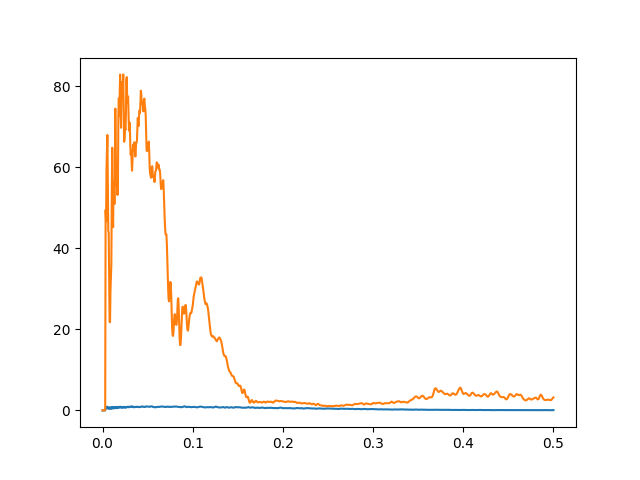

In [55]:
f, ax = plt.subplots()
plt.plot(sft[0], sks[0]/sks[0].max())
plt.plot(sft[0], sks[1]/sks[0].max())

In [48]:
#so that is the spectral kurtosis for 2 subbands (can extend to all subbands now)

In [49]:
#check windowing, make a quick windowing diagram. 
# do sk for same subband for 10 different window lengths, plot

In [50]:
window_lens = [12, 48, 96, 256, 512, 1024, 2048, 4096, 8192]

In [59]:
dt[:,1].shape

(7324219,)

In [62]:
stfs = stft(dt[:,1], window='hanning', axis=0, nperseg=12, nfft=8192)

In [ ]:
sks = get_sk(stfs[2])

In [ ]:
f, ax = plt.subplots()
plt.plot(sft[0], sks[0]/sks[0].max())

In [61]:
wndws = []
for i in window_lens:
    stfs = stft(dt[:,1], window='hamming', axis=0, nperseg=i, nfft=window_lens[-1])
    sk_i = get_sk(stfs[2])
    wndws.append(sk_i)

KeyboardInterrupt: 

In [ ]:
wndw_arr  = np.array(wndws)

In [ ]:
f, ax = plt.subplots()
plt.pcolormesh(stfs[1], stfs[0], np.abs(wndw_arr))